In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bct
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import wilcoxon
import seaborn as sns

/imaging/local/software/anaconda/2.4.1/2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches

In [4]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

In [744]:
def plot_adjacency_matrix(network):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=(double_column/3, double_column/3), dpi=300)
    im = plt.imshow(network, 
               cmap='jet',
               interpolation='none',
               vmin=0)
    ax = plt.gca()
    ax.grid('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)

In [ ]:
def bootstrap(data, num_samples, statistic, alpha):
    import numpy.random as npr
    
    n = len(data)
    idx = npr.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [7]:
folder = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/'

In [8]:
subject_list = sorted([subject.split('_')[-1] for subject in os.listdir(folder) if re.search('subject', subject)])

In [9]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix0/' + subject + '_dwi_' + model + '_' + threshold + '_matrix' + weight + '.txt'
    matrix = np.loadtxt(matrix)
    
    return matrix

## Plotting different matrix weights

In [754]:
networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(0), '', subject) for subject in subject_list]), 0, 3)
networks = np.asarray([bct.binarize(bct.threshold_proportional(network, 0.1)) for network in networks])
control_network = np.mean(networks[..., 0:7], axis=2)
ZDHHC9_network = np.mean(networks[..., 7:], axis=2)

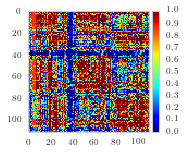

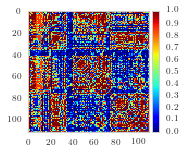

In [755]:
plot_adjacency_matrix(control_network)
plot_adjacency_matrix(ZDHHC9_network)

# Group differences using different defintions of edge weight

## 1. Streamline density

### 1.1 Streamline density with proportional thresholding

Streamline densities are absolute counts. These need to be thresholded to create binary graphs so that the graph metrics can be calculated. The binarization threshold may significantly influence the results. Therefore, a range of thresholds is tested. Further, thresholding may be proportional or to an absolute value. The proportional value conserves the overall density of the graph, but may level differences between cases and controls. In order to establish how robust differences are, both strategies are implemented and compared. 

In [13]:
def bootstrap(data, num_samples, statistic, alpha):
    import numpy.random as npr
    
    n = len(data)
    idx = npr.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [761]:
df = pd.DataFrame()

In [ ]:
def get_

In [762]:
threshold_range = np.arange(0.2, 1., 0.05)

for subject in subject_list:
    for threshold in threshold_range:
        # Loading the data
        network = load_data(folder, 'CSD', str(0), '', subject)

        # thresholding
        network = bct.threshold_proportional(network, threshold)

        # binarizing
        network[network > 0] = 1

        # calculate average clustering
        df.set_value(subject, str(threshold), np.mean(bct.clustering_coef_bu(network)))

# Adding the group variable
df['group'] = np.hstack([np.repeat('control', 7), np.repeat('ZDHHC9', 7)])

In [763]:
control_median = np.median(df[df['group'] == 'control'].values[:,0:-1], axis=0)
control_lowCI = [bootstrap(df[df['group'] == 'control'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

ZDHHC9_median = np.median(df[df['group'] == 'ZDHHC9'].values[:,0:-1], axis=0)
ZDHHC9_lowCI = [bootstrap(df[df['group'] == 'ZDHHC9'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

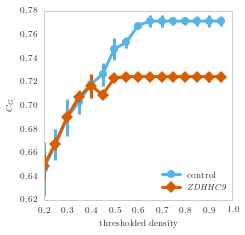

In [764]:
plt.figure(figsize=(single_column, single_column), dpi=600)

control = plt.errorbar(x = threshold_range,
             y = control_median,
             yerr = control_median - control_lowCI,
             marker = 'o',
             markersize = 8,
             color='#56B4E9',
             linewidth=3)

ZDHHC9 = plt.errorbar(x = threshold_range,
             y = ZDHHC9_median,
             yerr = ZDHHC9_median - ZDHHC9_lowCI,
             marker = 'D',
             markersize = 8,
             color='#D55E00',
             linewidth=3)

plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
plt.ylabel(r'$C_{G}$')
plt.xlabel(r'thresholded density')

The graph shows the group median of the average clustering coefficient at each density threshold for the *ZDHHC9* group (orange) and the control group (blue). The error bars show the bootstrapped 95% confidence interval.

### Comparing the area under the curve between groups
In order to get a treshold-free estimate of the average clustering coefficient, the area under the curve for the clustering coefficient across all thresholds is calculated. 

In [765]:
for subject in subject_list: 
    columns = [col for col in df.columns if col not in ['group', 'area']]
    area = np.cumsum(df.loc[[subject]][columns].values)[-1]
    df.set_value(subject, 'area', area)

In [766]:
control_area = df[df['group'] == 'ZDHHC9']['area'].values
ZDHHC9_area = df[df['group'] == 'control']['area'].values

In [767]:
wilcoxon(control_area, ZDHHC9_area)

WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)

### 1.2. Streamline density differences with absolute thresholding

In [776]:
df = pd.DataFrame()

In [777]:
threshold_range = np.arange(0, 500, 25)

for subject in subject_list:
    for threshold in threshold_range:
        # Loading the data
        network = load_data(folder, 'CSD', str(0), '', subject)

        # thresholding
        network = bct.threshold_absolute(network, threshold)

        # binarizing
        network[network > 0] = 1

        # calculate average clustering
        df.set_value(subject, str(threshold), np.mean(bct.clustering_coef_bu(network)))

# Adding the group variable
df['group'] = np.hstack([np.repeat('control', 7), np.repeat('ZDHHC9', 7)])

In [778]:
control_median = np.median(df[df['group'] == 'control'].values[:,0:-1], axis=0)
control_lowCI = [bootstrap(df[df['group'] == 'control'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

ZDHHC9_median = np.median(df[df['group'] == 'ZDHHC9'].values[:,0:-1], axis=0)
ZDHHC9_lowCI = [bootstrap(df[df['group'] == 'ZDHHC9'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

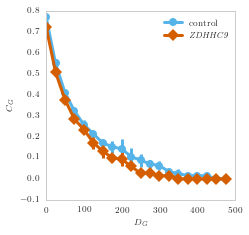

In [779]:
plt.figure(figsize=(single_column, single_column), dpi=600)

control = plt.errorbar(x = threshold_range,
             y = control_median,
             yerr = control_median - control_lowCI,
             marker = 'o',
             markersize = 8,
             color='#56B4E9',
             linewidth=3)

ZDHHC9 = plt.errorbar(x = threshold_range,
             y = ZDHHC9_median,
             yerr = ZDHHC9_median - ZDHHC9_lowCI,
             marker = 'D',
             markersize = 8,
             color='#D55E00',
             linewidth=3)

plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
plt.ylabel(r'$C_{G}$')
plt.xlabel(r'$D_{G}$')

In [780]:
for subject in subject_list: 
    columns = [col for col in df.columns if col not in ['group', 'area']]
    area = np.cumsum(df.loc[[subject]][columns].values)[-1]
    df.set_value(subject, 'area', area)

In [781]:
control_area = df[df['group'] == 'ZDHHC9']['area'].values
ZDHHC9_area = df[df['group'] == 'control']['area'].values

In [782]:
wilcoxon(control_area, ZDHHC9_area)

WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)

## 2. Streamline density normalized by ROI size

In [32]:
df = pd.DataFrame()

In [33]:
threshold_range = np.arange(0,90,10)

for subject in subject_list:
    for threshold in threshold_range:
        # Loading the data
        network = load_data(folder, 'CSD', str(threshold), '_ROI_normalized', subject)

        # binarizing
        network[network > 0] = 1

        # calculate average clustering
        df.set_value(subject, str(threshold), np.mean(bct.clustering_coef_bu(network)))

# Adding the group variable
df['group'] = np.hstack([np.repeat('control', 7), np.repeat('ZDHHC9', 7)])

In [34]:
control_median = np.median(df[df['group'] == 'control'].values[:,0:-1], axis=0)
control_lowCI = [bootstrap(df[df['group'] == 'control'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

ZDHHC9_median = np.median(df[df['group'] == 'ZDHHC9'].values[:,0:-1], axis=0)
ZDHHC9_lowCI = [bootstrap(df[df['group'] == 'ZDHHC9'][str(threshold)], 100, np.mean, 0.05)[0] for threshold in threshold_range]

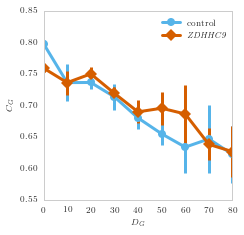

In [35]:
plt.figure(figsize=(single_column, single_column), dpi=600)

control = plt.errorbar(x = threshold_range,
             y = control_median,
             yerr = control_median - control_lowCI,
             marker = 'o',
             markersize = 8,
             color='#56B4E9',
             linewidth=3)

ZDHHC9 = plt.errorbar(x = threshold_range,
             y = ZDHHC9_median,
             yerr = ZDHHC9_median - ZDHHC9_lowCI,
             marker = 'D',
             markersize = 8,
             color='#D55E00',
             linewidth=3)

plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
plt.ylabel(r'$C_{G}$')
plt.xlabel(r'$D_{G}$')

In [36]:
for subject in subject_list: 
    columns = [col for col in df.columns if col not in ['group', 'area']]
    area = np.cumsum(df.loc[[subject]][columns].values)[-1]
    df.set_value(subject, 'area', area)

In [37]:
control_area = df[df['group'] == 'ZDHHC9']['area'].values
ZDHHC9_area = df[df['group'] == 'control']['area'].values

In [38]:
wilcoxon(control_area, ZDHHC9_area)

WilcoxonResult(statistic=7.0, pvalue=0.23672357063785732)

## 3. Streamline density normalized 

In [39]:
df = pd.DataFrame()

In [40]:
threshold_range = np.arange(0,90,10)

for subject in subject_list:
    for threshold in threshold_range:
        # Loading the data
        network = load_data(folder, 'CSD', str(threshold), '_length_normalized', subject)

        # binarizing
        network[network > 0] = 1

        # calculate average clustering
        df.set_value(subject, str(threshold), np.mean(bct.clustering_coef_bu(network)))

# Adding the group variable
df['group'] = np.hstack([np.repeat('control', 7), np.repeat('ZDHHC9', 7)])

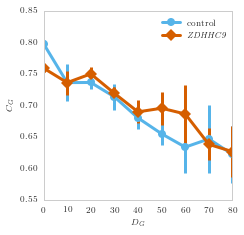

In [41]:
plt.figure(figsize=(single_column, single_column), dpi=600)

control = plt.errorbar(x = threshold_range,
             y = control_median,
             yerr = control_median - control_lowCI,
             marker = 'o',
             markersize = 8,
             color='#56B4E9',
             linewidth=3)

ZDHHC9 = plt.errorbar(x = threshold_range,
             y = ZDHHC9_median,
             yerr = ZDHHC9_median - ZDHHC9_lowCI,
             marker = 'D',
             markersize = 8,
             color='#D55E00',
             linewidth=3)

plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
plt.ylabel(r'$C_{G}$')
plt.xlabel(r'$D_{G}$')

In [42]:
for subject in subject_list: 
    columns = [col for col in df.columns if col not in ['group', 'area']]
    area = np.cumsum(df.loc[[subject]][columns].values)[-1]
    df.set_value(subject, 'area', area)

In [43]:
control_area = df[df['group'] == 'ZDHHC9']['area'].values
ZDHHC9_area = df[df['group'] == 'control']['area'].values

In [44]:
wilcoxon(control_area, ZDHHC9_area)

WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)

## 4. Weighted by Generalized FA